Dataset Preparation and Modeling for Air Quality Prediction

# Importing Required Libraries

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px

# Step 1: Data Loading and Initial Cleaning
Load the dataset

In [6]:
df = pd.read_csv("selected_datasets/Air_Quality.csv").drop(["Message"], axis=1)
print("Dataset Loaded. Initial Shape:", df.shape)

Dataset Loaded. Initial Shape: (18025, 11)


In [7]:
df

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1
...,...,...,...,...,...,...,...,...,...,...,...
18020,816914,643,Annual vehicle miles traveled,Million miles,per square mile,CD,503.0,Tottenville and Great Kills (CD3),2019,01/01/2019,12.9
18021,816913,643,Annual vehicle miles traveled,Million miles,per square mile,CD,503.0,Tottenville and Great Kills (CD3),2010,01/01/2010,14.7
18022,816872,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,208.0,Canarsie - Flatlands,2010,01/01/2010,43.4
18023,816832,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,407.0,Southwest Queens,2010,01/01/2010,65.8


Drop rows with any missing values

In [8]:
df.dropna(inplace=True)
print("Shape After Dropping NA Rows:", df.shape)

Shape After Dropping NA Rows: (18016, 11)


In [9]:
df.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1


# Step 2: Feature Engineering
Convert Start_Date column to datetime format and extract date-related features

In [10]:
df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce')
df['year'] = df['Start_Date'].dt.year
df['month'] = df['Start_Date'].dt.month
df['day'] = df['Start_Date'].dt.day

In [11]:
df = df.drop(columns=['Unique ID', 'Start_Date'])
print("Dataset After Dropping Unnecessary Columns:", df.columns)

Dataset After Dropping Unnecessary Columns: Index(['Indicator ID', 'Name', 'Measure', 'Measure Info', 'Geo Type Name',
       'Geo Join ID', 'Geo Place Name', 'Time Period', 'Data Value', 'year',
       'month', 'day'],
      dtype='object')


# Step 3: Define Target and Features

In [12]:
target_column = 'Data Value'
X = df.drop(columns=[target_column])
y = df[target_column]

# Step 4: Data Preprocessing Pipelines
Separate numerical and categorical features

In [13]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [14]:
# Numerical and Categorical Transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [15]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Combine preprocessing steps

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 5: Model Training and Evaluation with Multiple Regressors
Dictionary to store models and their names

In [17]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [18]:
# Split dataset into training and testing sets for initial evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate each model

In [19]:
results = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2}
    print(f"{model_name} Performance:")
    print("Mean Squared Error:", mse)
    print("R^2 Score:", r2)
    print("-" * 30)

Linear Regression Performance:
Mean Squared Error: 196.65295767023932
R^2 Score: 0.6194951883262301
------------------------------
Ridge Regression Performance:
Mean Squared Error: 196.78160026803354
R^2 Score: 0.6192462771070609
------------------------------
Lasso Regression Performance:
Mean Squared Error: 416.1205455608684
R^2 Score: 0.19484623217448538
------------------------------
Decision Tree Performance:
Mean Squared Error: 43.146770255271925
R^2 Score: 0.9165150939766504
------------------------------
Random Forest Performance:
Mean Squared Error: 29.23488879439514
R^2 Score: 0.9434332644329285
------------------------------


# Step 6: Principal Component Analysis (PCA)
Apply PCA for dimensionality reduction and visualization

In [20]:
# Encode categorical features and standardize numerical features for PCA
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [21]:
# Fit PCA model and transform data into 3 principal components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [22]:
# Create DataFrame for PCA results with target column for visualization
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Data Value'] = y.values

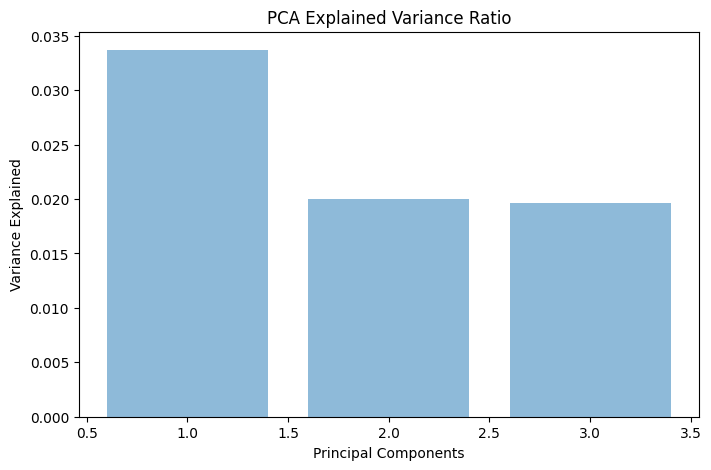

In [23]:
# Visualize explained variance ratio for each principal component
plt.figure(figsize=(8, 5))
plt.bar(range(1, 4), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Variance Explained')
plt.xlabel('Principal Components')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [24]:
# 3D Scatter Plot for First Three Principal Components
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Data Value',
    title="3D PCA Plot (First Three Principal Components)",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
    color_continuous_scale="Viridis"
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
                    xaxis_title="Principal Component 1",
                    yaxis_title="Principal Component 2",
                    zaxis_title="Principal Component 3"))
fig.show()

# Step 7: Correlation Analysis
Check the correlation between 'Data Value' and principal components

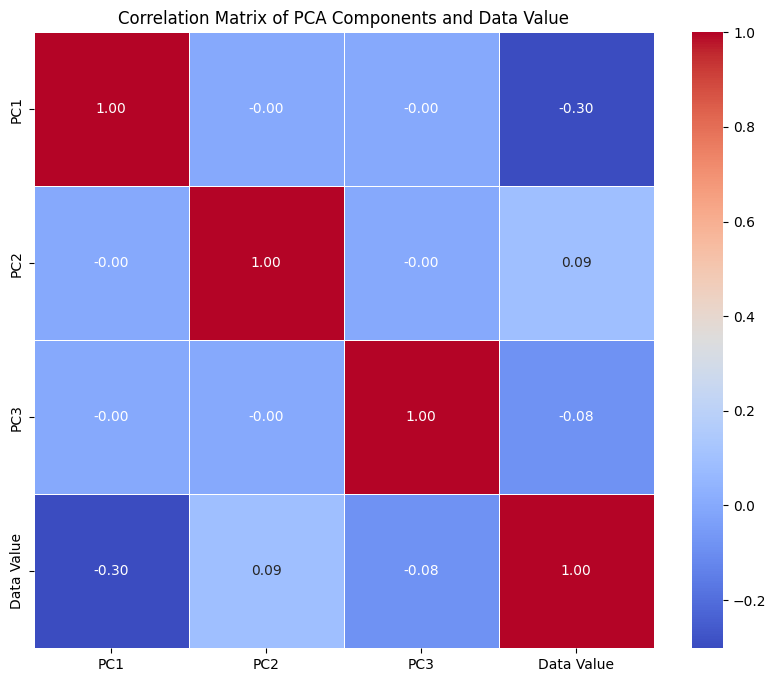

In [25]:
# Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pca_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of PCA Components and Data Value")
plt.show()

# Step 8: Stratified Train-Test Split for Final Dataset Submission
Convert target values to bins for stratification

In [26]:
bins = pd.qcut(y, q=10, duplicates='drop')  # Create quantile bins
X['stratify_bins'] = bins  # Add bins as a new column for stratification

In [27]:
# Perform stratified split based on created bins
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
    X.drop(columns=['stratify_bins']), y, test_size=0.2, stratify=X['stratify_bins'], random_state=42
)

<Axes: xlabel='Data Value', ylabel='Count'>

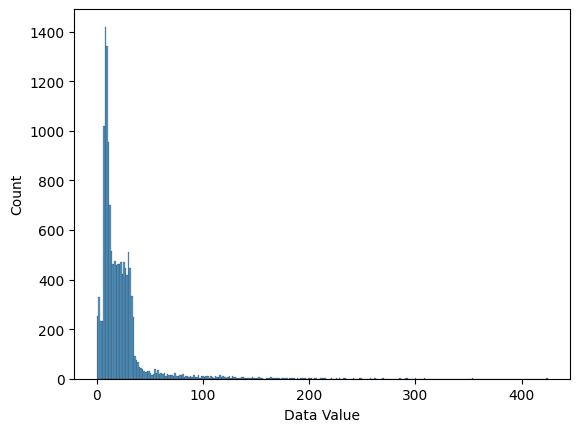

In [28]:
sns.histplot(y_final_train)

<Axes: xlabel='Data Value', ylabel='Count'>

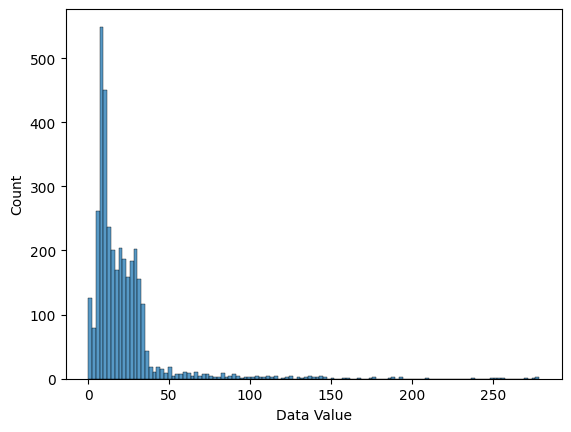

In [29]:
sns.histplot(y_final_test)

In [30]:
stratified_train_set = pd.concat((X_final_train, y_final_train), axis=1)
stratified_test_set = pd.concat((X_final_test, y_final_test), axis=1)

In [31]:
stratified_train_set.to_csv("output_datasets/Air_Quality_Train.csv")
stratified_test_set.to_csv("output_datasets/Air_Quality_Test.csv")
print("[Done]")

[Done]
